### 0. Extra Config as my pc has multiple JVMs 

In [1]:
!/usr/libexec/java_home -V

Matching Java Virtual Machines (8):
    23 (arm64) "Eclipse Adoptium" - "OpenJDK 23" /Library/Java/JavaVirtualMachines/temurin-23.jdk/Contents/Home
    19.0.2 (arm64) "Amazon.com Inc." - "Amazon Corretto 19" /Users/him/Library/Java/JavaVirtualMachines/corretto-19.0.2/Contents/Home
    17.0.8 (arm64) "Oracle Corporation" - "Java SE 17.0.8" /Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home
    11.0.23 (arm64) "Amazon.com Inc." - "Amazon Corretto 11" /Users/him/Library/Java/JavaVirtualMachines/corretto-11.0.23/Contents/Home
    11.0.22 (arm64) "Eclipse Adoptium" - "OpenJDK 11.0.22" /Library/Java/JavaVirtualMachines/temurin-11.jdk/Contents/Home
    1.8.431.10 (x86_64) "Oracle Corporation" - "Java" /Library/Internet Plug-Ins/JavaAppletPlugin.plugin/Contents/Home
    1.8.0_412 (arm64) "Amazon" - "Amazon Corretto 8" /Users/him/Library/Java/JavaVirtualMachines/corretto-1.8.0_412/Contents/Home
    1.8.0_412 (x86_64) "Amazon" - "Amazon Corretto 8" /Users/him/Library/Java/JavaVirtualMach

In [2]:
import os

In [3]:
java_path = "/Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home"
java_home = os.environ.get('JAVA_HOME', None)

print("Existing Java Home: ",java_home)

if (not java_home) or (java_path not in java_home):
    os.environ['JAVA_HOME'] = java_path

print("Updated Java Home: ",os.environ.get('JAVA_HOME', None))

Existing Java Home:  None
Updated Java Home:  /Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home


In [4]:
# print java version

os.system('java -version')

java version "17.0.8" 2023-07-18 LTS
Java(TM) SE Runtime Environment (build 17.0.8+9-LTS-211)
Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)


0

### 1. Import library

In [5]:
# $example on$
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
# $example off$
from pyspark.sql import SparkSession

### 2. Load data

In [6]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

### 3. Prepocessing

In [7]:
train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
train_df['Sex'] = train_df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())
train_df['Embarked'] = train_df['Embarked'].apply(lambda x: 0 if x == 'S' else 1)


In [ ]:
spark = SparkSession\
        .builder\
        .appName("linear-svc")\
        .getOrCreate()


24/11/28 16:02:43 WARN Utils: Your hostname, Yuen-Man-Hims-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.89.166.58 instead (on interface en0)
24/11/28 16:02:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/28 16:02:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
data = spark.createDataFrame(train_df)
train, valid = data.randomSplit([0.6, 0.4], seed=12345)

assembler = VectorAssembler(
    inputCols = train_df.columns[1:].to_list(),
    outputCol = "features")
train = assembler.transform(train)
valid = assembler.transform(valid)

## 4. Model

24/11/28 16:02:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/11/28 16:02:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Coefficients: [-0.1049191093622976,-1.9885377554676447,-0.003881682607849011,-0.12804653019784323,0.027171404178357842,-0.00010755980851310895,0.052190453474727505]
Intercept: 1.3491904251828788
Test set accuracy = 0.7542857142857143
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       216
           1       0.69      0.64      0.67       134

    accuracy                           0.75       350
   macro avg       0.74      0.73      0.74       350
weighted avg       0.75      0.75      0.75       350



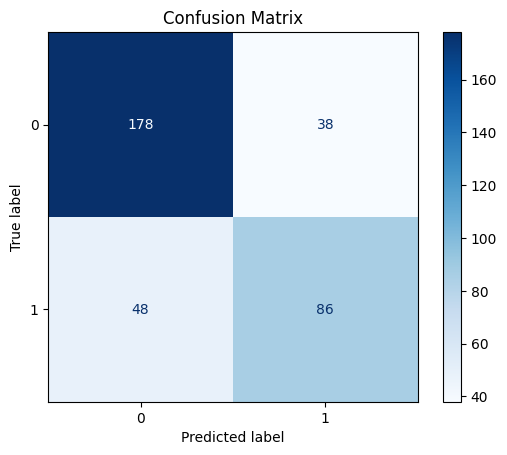

In [10]:
lsvc = LinearSVC(maxIter=10, regParam=0.1, labelCol="Survived", featuresCol="features")

# Fit the model
lsvcModel = lsvc.fit(train)

# Print the coefficients and intercept for linear SVC
print("Coefficients: " + str(lsvcModel.coefficients))
print("Intercept: " + str(lsvcModel.intercept))

result = lsvcModel.transform(valid)
predictionAndLabels = result.select("prediction", "Survived")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy", labelCol="Survived", predictionCol="prediction")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

# Get predictions
y_true = result.select("Survived").toPandas()
y_pred = result.select("prediction").toPandas()

# Create classification report
print(classification_report(y_true, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()